## Khai báo thư viện 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os 
import joblib
from sklearn.model_selection import GridSearchCV

## Tải dữ liệu 

### Thiết lập đường dẫn 

In [28]:
PROCESSED_DATA_PATH = '../data/03_processed/'
MODEL_OUTPUT_PATH = '../models/'

# Tạo thư mục lưu model nếu chưa tồn tại
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

### Tải dữ liệu đặc trưng

In [29]:
# Hàm tải đặc trưng cụ thể từ file .npz
def load_specific_features(file_path, feature_key='X_hist'):
    try:
        data = np.load(file_path)
        X = data[feature_key]
        y = data['y']
        return X, y
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại '{file_path}'")
        return None, None
    except KeyError:
        print(f"Lỗi: Không tìm thấy key '{feature_key}' trong file '{file_path}'.")
        print(f"Các key có sẵn trong file là: {list(data.keys())}")
        return None, None

# Chỉ định loại đặc trưng histogram
FEATURE_TYPE_TO_LOAD = 'X_hist'

print(f"Đang tiến hành tải bộ đặc trưng: '{FEATURE_TYPE_TO_LOAD}'...")

# Tải dữ liệu train, validation và test
X_train, y_train = load_specific_features(os.path.join(PROCESSED_DATA_PATH, 'train_features.npz'), feature_key=FEATURE_TYPE_TO_LOAD)
X_val, y_val = load_specific_features(os.path.join(PROCESSED_DATA_PATH, 'val_features.npz'), feature_key=FEATURE_TYPE_TO_LOAD)
X_test, y_test = load_specific_features(os.path.join(PROCESSED_DATA_PATH, 'test_features.npz'), feature_key=FEATURE_TYPE_TO_LOAD)

# Kiểm tra xem dữ liệu đã được tải thành công chưa
if X_train is not None and y_train is not None and y_val is not None and y_test is not None:
    print("\nTải dữ liệu thành công!")
    print(f"Shape tập train: X={X_train.shape}, y={y_train.shape}")
    print(f"Shape tập val:   X={X_val.shape}, y={y_val.shape}")
    print(f"Shape tập test:  X={X_test.shape}, y={y_test.shape}")
else:
    print("\nQuá trình tải dữ liệu thất bại. Vui lòng kiểm tra lại lỗi ở trên.")

Đang tiến hành tải bộ đặc trưng: 'X_hist'...

Tải dữ liệu thành công!
Shape tập train: X=(8226, 512), y=(8226,)
Shape tập val:   X=(2742, 512), y=(2742,)
Shape tập test:  X=(2743, 512), y=(2743,)


## Chuẩn hoá dữ liệu 

In [30]:
scaler = StandardScaler()

# Fit scaler CHỈ trên tập train
print("Fitting scaler trên dữ liệu training...")
scaler.fit(X_train)

# Transform cho cả 3 tập
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Đã chuẩn hóa dữ liệu cho cả 3 tập train, val và test.")
print(f"Giá trị trung bình của cột đầu tiên trong X_train sau khi scale: {X_train_scaled[:, 0].mean():.4f}")
print(f"Giá trị trung bình của cột đầu tiên trong X_test sau khi scale: {X_test_scaled[:, 0].mean():.4f} (lưu ý: không nhất thiết bằng 0)")


Fitting scaler trên dữ liệu training...
Đã chuẩn hóa dữ liệu cho cả 3 tập train, val và test.
Giá trị trung bình của cột đầu tiên trong X_train sau khi scale: 0.0000
Giá trị trung bình của cột đầu tiên trong X_test sau khi scale: -0.0160 (lưu ý: không nhất thiết bằng 0)


## Huấn luyện mô hình

### Huấn luyện mô hình SVM với tham số mặc định

In [32]:
print("Bắt đầu huấn luyện mô hình SVM...")

# Khởi tạo mô hình SVM với các tham số phổ biến
model = SVC(kernel='rbf', C=1.0, gamma=0.01, class_weight='balanced', probability=True, random_state=42)

# Huấn luyện mô hình trên dữ liệu training
model.fit(X_train_scaled, y_train)

print("Huấn luyện mô hình hoàn tất!")

Bắt đầu huấn luyện mô hình SVM...
Huấn luyện mô hình hoàn tất!


### Kết quả huấn luyện của mô hình SVM cơ bản


ĐỘ CHÍNH XÁC (ACCURACY) TRÊN TẬP TEST: 24.61%

BÁO CÁO PHÂN LOẠI CHI TIẾT TRÊN TẬP TEST:
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       100
           1       0.23      0.22      0.22       100
           2       0.34      0.51      0.41       100
           3       0.38      0.27      0.31       157
           4       0.14      0.06      0.08       100
           5       0.08      0.04      0.05        98
           6       0.50      0.40      0.44       169
           7       0.19      0.10      0.13       100
           8       0.31      0.20      0.24       100
           9       0.10      0.08      0.09       113
          10       0.41      0.42      0.42       100
          11       0.21      0.18      0.19        96
          12       0.02      0.01      0.01       106
          13       0.15      0.10      0.12       104
          14       0.10      0.59      0.17       116
          15       0.30      0.12      0.17  

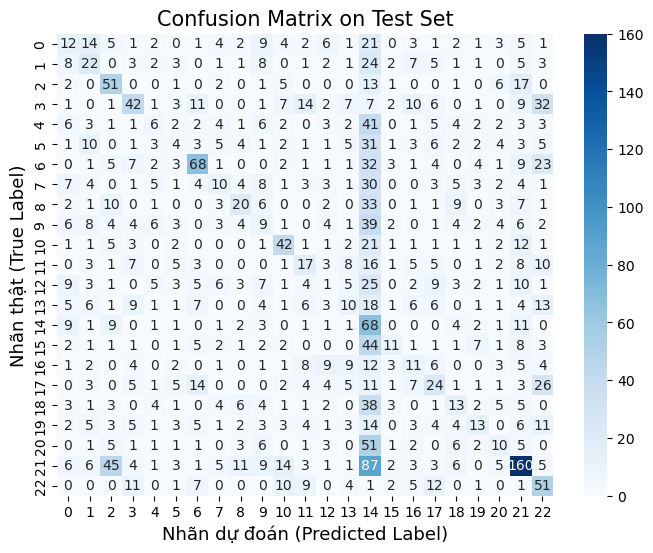

In [33]:
# Dự đoán nhãn cho tập test
y_pred = model.predict(X_test_scaled)

# --- 5.1. Accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐỘ CHÍNH XÁC (ACCURACY) TRÊN TẬP TEST: {accuracy * 100:.2f}%\n")


# --- 5.2. Classification Report ---
print("BÁO CÁO PHÂN LOẠI CHI TIẾT TRÊN TẬP TEST:")
print(classification_report(y_test, y_pred))


# --- 5.3. Confusion Matrix ---
print("MA TRẬN NHẦM LẪN TRÊN TẬP TEST:")
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y_train) # Lấy tên các lớp từ dữ liệu train

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=13)
plt.ylabel('Nhãn thật (True Label)', fontsize=13)
plt.title('Confusion Matrix on Test Set', fontsize=15)
plt.show()

### Sử dụng Grid Search để tìm kiếm siêu tham số cho mô hình SVM

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

if 'X_train_scaled' in locals():
    print("Bắt đầu Grid Search cho SVM...")

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 0.1, 0.01],
        'kernel': ['rbf']
    }

    grid_search = GridSearchCV(
        estimator=SVC(probability=True, random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)
    print("Hoàn tất Grid Search!")
    
    # In ra kết quả tìm được
    print("\nKết quả Grid Search:")
    print("Siêu tham số tốt nhất:", grid_search.best_params_)
    print(f"Độ chính xác cross-validation tốt nhất: {grid_search.best_score_ * 100:.2f}%")
else:
    print("Dữ liệu chưa sẵn sàng.")


Bắt đầu Grid Search cho SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.6min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.6min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.1min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.1min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.2min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.2min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.2min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.9min
[CV] END ........

In [35]:
if 'grid_search' in locals():
    best_svm_model = grid_search.best_estimator_

    print("\nHuấn luyện mô hình SVM với tham số tối ưu...")
    best_svm_model.fit(X_train_scaled, y_train)
    print("Hoàn tất huấn luyện mô hình tối ưu!")
else:
    print("Chưa có kết quả Grid Search để huấn luyện.")


Huấn luyện mô hình SVM với tham số tối ưu...
Hoàn tất huấn luyện mô hình tối ưu!


### Kết quả huấn luyện sau khi tinh chỉnh 

In [36]:
if 'best_svm_model' in locals():
    # Dự đoán trên tập train và test
    y_pred_train = best_svm_model.predict(X_train_scaled)
    y_pred_test = best_svm_model.predict(X_test_scaled)

    # Tính độ chính xác
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print("\nKết quả mô hình SVM sau Grid Search:")
    print(f"Accuracy (Train): {acc_train * 100:.2f}%")
    print(f"Accuracy (Test):  {acc_test * 100:.2f}%")

    print("\nBáo cáo phân loại (Test):")
    print(classification_report(y_test, y_pred_test))
else:
    print("Chưa có mô hình SVM để đánh giá.")


Kết quả mô hình SVM sau Grid Search:
Accuracy (Train): 85.34%
Accuracy (Test):  31.43%

Báo cáo phân loại (Test):
              precision    recall  f1-score   support

           0       0.13      0.13      0.13       100
           1       0.25      0.30      0.27       100
           2       0.45      0.60      0.52       100
           3       0.35      0.43      0.39       157
           4       0.12      0.10      0.11       100
           5       0.14      0.09      0.11        98
           6       0.46      0.52      0.49       169
           7       0.19      0.15      0.17       100
           8       0.22      0.19      0.20       100
           9       0.16      0.15      0.16       113
          10       0.45      0.54      0.49       100
          11       0.25      0.17      0.20        96
          12       0.04      0.03      0.03       106
          13       0.15      0.12      0.14       104
          14       0.28      0.28      0.28       116
          15       0

## Lưu trữ model

In [ ]:
# model_file = os.path.join(MODEL_OUTPUT_PATH, 'svm_histogram_model.joblib')
# scaler_file = os.path.join(MODEL_OUTPUT_PATH, 'histogram_scaler.joblib')

# # Lưu model
# joblib.dump(model, model_file)
# print(f"Đã lưu mô hình vào: '{model_file}'")

# # Lưu scaler
# joblib.dump(scaler, scaler_file)
# print(f"Đã lưu scaler vào: '{scaler_file}'")

Đã lưu mô hình vào: '../models/svm_histogram_model.joblib'
Đã lưu scaler vào: '../models/histogram_scaler.joblib'
